In [1]:
%matplotlib inline
import numpy as np

import scipy.stats as stat
import scipy.integrate as pyint
import scipy.optimize as opt

import matplotlib.pyplot as plt
from matplotlib import cm

# Unfolding
## Exercise 1
### Part a

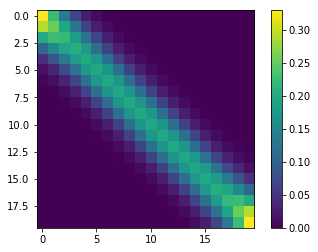

In [2]:
Nbins = 20
bin_edges = np.linspace(0,100,Nbins+1)
sigma = 2*(bin_edges[1]-bin_edges[0])
c_norm = 1./(np.sqrt(2)*sigma*pyint.quad(lambda x: np.exp(-x**2),0,100)[0])
def res_function(x,y):
    return np.exp(-(x-y)**2/(2*sigma**2))/pyint.quad(lambda x: np.exp(-(x-y)**2/(2*sigma**2)),0,100)[0]

def int_res_fun(y,xa,xb):
    return pyint.quad(lambda x: res_function(x,y),xa,xb)[0]

bin_midpoint = .5*(bin_edges[1:]+bin_edges[:-1])
R_matrix = np.empty((Nbins,Nbins))
for i in range(Nbins):
    for j in range(Nbins):
        R_matrix[i,j]=int_res_fun(bin_midpoint[j],bin_edges[i],bin_edges[i+1])
        
plt.imshow(R_matrix)
plt.colorbar()

### Part b

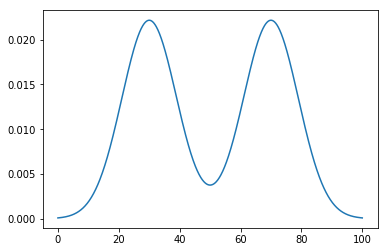

In [3]:
sigma_data = 9
#c_data = 1./(np.sqrt(2)*sigma_data*pyint.quad(lambda x: np.exp(-x**2),0,100)[0])

def f_true(x):
    return (np.exp(-(x-30)**2/(2*sigma_data**2))+np.exp(-(x-70)**2/(2*sigma_data**2)))/pyint.quad(lambda x: (np.exp(-(x-30)**2/(2*sigma_data**2))+np.exp(-(x-70)**2/(2*sigma_data**2))),0,100)[0]

x_plot = np.linspace(0,100,1000)
plt.plot(x_plot,f_true(x_plot))

In [4]:
mutot=100000
p=np.zeros(Nbins)
for i in range(Nbins):
    p[i]=pyint.quad(lambda x: f_true(x),bin_edges[i],bin_edges[i+1])[0]
    
mu_hist=mutot*p   

<Container object of 20 artists>

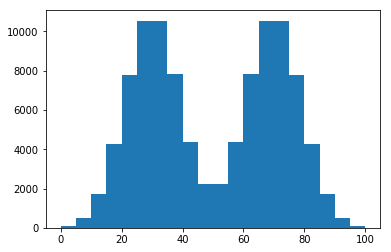

In [5]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0])

<Container object of 20 artists>

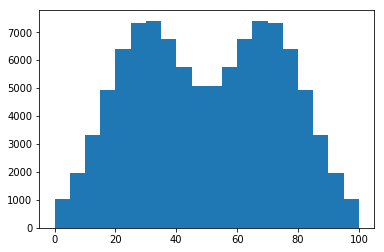

In [6]:
nu_hist = np.dot(R_matrix,mu_hist)
plt.bar(bin_midpoint,nu_hist,width=bin_edges[1]-bin_edges[0])

<Container object of 20 artists>

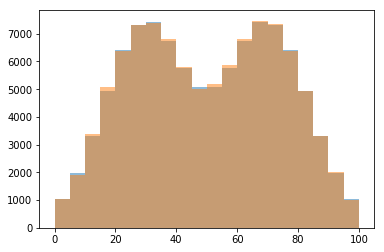

In [7]:
N_d = len(nu_hist)
poisson = stat.poisson(nu_hist)
Nexperiment_d = poisson.rvs(N_d)
plt.figure()
plt.bar(bin_midpoint,nu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5)
plt.bar(bin_midpoint,Nexperiment_d,width=bin_edges[1]-bin_edges[0],alpha=0.5)

### Part e

<Container object of 20 artists>

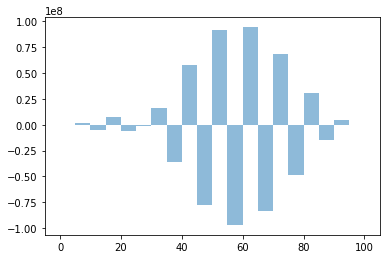

In [8]:
R_inv = np.linalg.inv(R_matrix)
mu_estimated_inv = np.dot(R_inv,Nexperiment_d)
plt.figure()
plt.bar(bin_midpoint,mu_estimated_inv,width=bin_edges[1]-bin_edges[0],alpha=0.5)
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5)

### Part f

In [9]:
def chi2_mu_hist(mu_hist_try):
    nu_hist_try = np.dot(R_matrix,mu_hist_try)
    logp_i = (nu_hist_try-Nexperiment_d)**2/nu_hist_try
    return sum(logp_i)

#bound_f = tuple([(0,None) for i in range(N_d)]) No usar bounds
minimization_chi = opt.minimize(chi2_mu_hist,Nexperiment_d)#,bounds=bound_f)
mu_estimated_chi = minimization_chi['x']

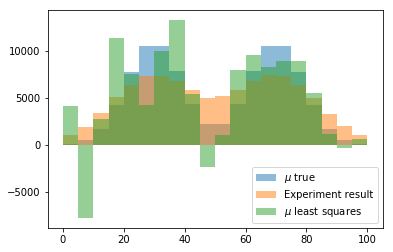

In [10]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ true')
plt.bar(bin_midpoint,Nexperiment_d,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'Experiment result')
plt.bar(bin_midpoint,mu_estimated_chi,width=bin_edges[1]-bin_edges[0],alpha=0.5, label= '$\mu$ least squares')
plt.legend()

In [11]:
def like_mu_hist(mu_hist_try):
    nu_hist_try = np.dot(R_matrix,mu_hist_try)
    logp_i = -np.log(nu_hist_try)*Nexperiment_d+(Nexperiment_d*np.log(Nexperiment_d)-Nexperiment_d)+nu_hist_try
    return np.sum(logp_i)

#bound_f = tuple([(0,None) for i in range(N_d)]) #No usar bounds
minimization_like = opt.minimize(like_mu_hist,Nexperiment_d)#,bounds=bound_f)
mu_estimated_like = minimization_like['x']

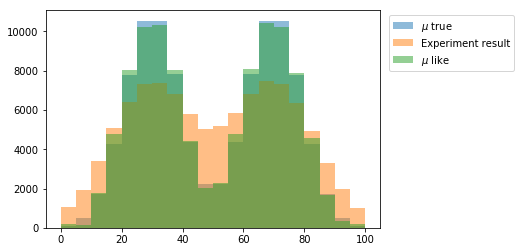

In [12]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ true')
plt.bar(bin_midpoint,Nexperiment_d,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'Experiment result')
plt.bar(bin_midpoint,mu_estimated_like,width=bin_edges[1]-bin_edges[0],alpha=0.5, label= '$\mu$ like')
plt.legend(loc=2,bbox_to_anchor=(1.01, 1))

## Correction factors
It s based on an iteration that does not converge! Yay!

In [13]:
N_g = 10
mus_g = np.empty((N_g+1,len(Nexperiment_d)))
nus_g = np.empty((N_g,len(Nexperiment_d)))
mus_g[0,:] = Nexperiment_d
for i in range(N_g):
    nus_g[i,:] = np.dot(R_matrix,mus_g[i,:])
    c = mus_g[i,:]/nus_g[i,:]
    mus_g[i+1,:] = c*Nexperiment_d

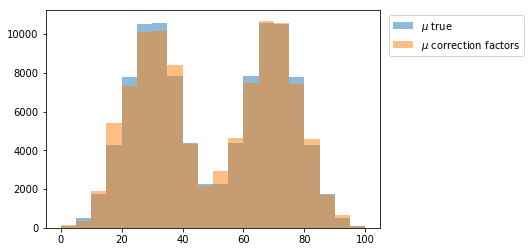

In [14]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ true')
plt.bar(bin_midpoint,mus_g[-1,:],width=bin_edges[1]-bin_edges[0],alpha=0.5, label= '$\mu$ correction factors')
plt.legend(loc=2,bbox_to_anchor=(1.01, 1))

## Forward unfolding

In [15]:
def f_param(x,theta):
    mean1,mean2,s1,s2,norm = theta
    return norm*(np.exp(-(x-mean1)**2/(2*s1**2))+np.exp(-(x-mean2)**2/(2*s2**2)))

def chi2_forward(theta):
    nu_i = np.dot(R_matrix,f_param(bin_midpoint,theta))
    chi = (nu_i-Nexperiment_d)**2/Nexperiment_d
    return sum(chi)

In [16]:
minimization_fow = opt.minimize(chi2_forward,(20,60,5,15,5000))
theta_estimated_fow = minimization_fow['x']
print(theta_estimated_fow)

[  2.99144012e+01   6.98460517e+01   9.07167668e+00   9.16872743e+00
   1.09849083e+04]


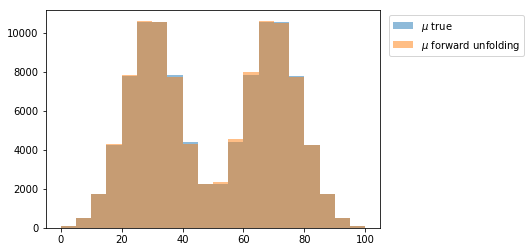

In [17]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ true')
plt.bar(bin_midpoint,f_param(bin_midpoint,theta_estimated_fow),width=bin_edges[1]-bin_edges[0],
        alpha=0.5, label= '$\mu$ forward unfolding')
plt.legend(loc=2,bbox_to_anchor=(1.01, 1))

# Exercise 2

## Part a
Done in ex1
## Part b
we are going to use maximum entropy
## Part c

In [18]:
def s_mu_eq7(mu_try):
    mu_tot = sum(mu_try)
    p = mu_try/mu_tot
    return -sum(p*np.log(p))

n_tot = sum(Nexperiment_d)
def eq7_max_entropy(mu_try,alpha,landa):
    return -alpha*like_mu_hist(mu_try)+s_mu_eq7(mu_try)+landa*(sum(np.dot(R_matrix,mu_try))-n_tot)

In [19]:
alphavec = np.logspace(-1,12,50)
mus_reg = np.empty((len(alphavec),len(Nexperiment_d)))
lambdas_reg = np.empty(len(alphavec))
bound_f = tuple([(0,None) for i in range(N_d)]+[(None,None)])
for i,alpha in enumerate(alphavec):
    res_alph = opt.minimize(lambda mulanda: -eq7_max_entropy(mulanda[:-1],alpha,mulanda[-1]),
                            np.append(Nexperiment_d,5),bounds=bound_f)
    mus_reg[i,:] = res_alph['x'][:-1]
    lambdas_reg[i] = res_alph['x'][-1]

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [20]:
#np.savetxt('mus_reg_2.dat',mus_reg)
#np.savetxt('alphas_reg_2.dat',alphavec)
#np.savetxt('lambdas_reg_2.dat',lambdas_reg)

In [21]:
#mus_reg = np.loadtxt('mus_reg_2.dat')
#alphavec = np.loadtxt('alphas_reg_2.dat')
#lambdas_reg = np.loadtxt('lambdas_reg_2.dat')

## Part d

In [20]:
V = np.eye(N_d)*Nexperiment_d
A = np.zeros((N_d+1,N_d+1))
B = np.ones((N_d+1,N_d))
delta = np.eye(N_d)
for k,alpha in enumerate(alphavec):
    mutot=sum(mus_reg[k,:])
    for i in range(N_d):
        A[i,N_d] = -sum(R_matrix[:,i])
        A[N_d,i] = -sum(R_matrix[:,i])
        B[i,:] = R_matrix[i,:]/np.dot(R_matrix,mus_reg[k,:])
        for j in range(N_d):
            A[i,j]=-alphavec[k]*sum(Nexperiment_d*R_matrix[:,i]*R_matrix[:,j]/np.dot(R_matrix,mus_reg[k,:])**2)+(1.
                    -delta[i,j]*mutot/mus_reg[k,i]+np.log(mus_reg[k,i]*mus_reg[k,j]/mutot)+2*s_mu_eq7(mus_reg[k,:]))/mutot**2
    C = -np.dot(np.linalg.inv(A),B)[:N_d,:]
    U = np.dot(np.dot(C,V),np.transpose(C))

In [21]:
# Alternative way of defining A and B
V = np.eye(N_d)*Nexperiment_d
Aopt = np.zeros((N_d+1,N_d+1))
Bopt = np.ones((N_d+1,N_d))
ones = np.ones((N_d,N_d))
Aopt[:N_d,N_d] = -np.sum(R_matrix,axis=1)
Aopt[N_d,:N_d] = -np.sum(R_matrix,axis=1)
Rprod = np.empty((N_d,N_d,N_d))

for i in range(N_d):
    for j in range(N_d):
        Rprod[i,j,:] = Nexperiment_d*R_matrix[:,i]*R_matrix[:,j]

for k,alpha in enumerate(alphavec):
    mutot=sum(mus_reg[k,:])
    mutot2 = mutot**2
    p_k = mus_reg[k,:]/mutot
    entropy = -2*sum(p_k*np.log(p_k))
    nu_k = np.dot(R_matrix,mus_reg[k,:])
    nu_k2 = nu_k**2
    Bopt[:N_d,:] = R_matrix/(ones*nu_k)
    for i in range(N_d):
        Aopt[i,i] = -alpha*sum(Rprod[i,i,:]/nu_k2)+\
                    (1.-mutot/mus_reg[k,i]+np.log(mus_reg[k,i]*p_k[i])+entropy)/mutot**2
        ai = -alpha*np.sum(Rprod[i,:i,:]/nu_k2,axis=1)+(1.+np.log(mus_reg[k,i]*p_k[:i])+entropy)/mutot2
        Aopt[i,:i] = ai
        Aopt[:i,i] = ai

    C = -np.dot(np.linalg.inv(Aopt),Bopt)[:N_d,:]
    U = np.dot(np.dot(C,V),np.transpose(C))

Tychonof S

In [24]:
def s_mu_eq7(mu_try):
    mu_tot = sum(mu_try)
    p = mu_try/mu_tot
    return -sum(p*np.log(p))

G=np.diag(6*np.ones(N_d))+np.diag(-4*np.ones(N_d-1),k=1)+np.diag(-4*np.ones(N_d-1),k=-1)
G[0,0]=1
G[-1,-1]=1
G[1,1]=5
G[-2,-2]=5
G[0,1]=-2
G[1,0]=-2
G[-1,-2]=-2
G[-2,-1]=-2

def s_mu_tycho(mu_try):
    return -np.dot(mu_try.transpose(),np.dot(G,mu_try))


def like_mu(mu_hist_try):
    nu_hist_try = np.dot(R_matrix,mu_hist_try)
    logp_i = np.log(nu_hist_try)*Nexperiment_d-(Nexperiment_d*np.log(Nexperiment_d)-Nexperiment_d)-nu_hist_try
    
    return np.sum(logp_i)

n_tot = sum(Nexperiment_d)
def eq7_max_entropy(mu_try,alpha,landa):
    return alpha*like_mu(mu_try)+s_mu_tycho(mu_try)+landa*(sum(np.dot(R_matrix,mu_try))-n_tot)

In [39]:
alphavec = np.logspace(-1,12,50)
mus_reg = np.empty((len(alphavec),len(Nexperiment_d)))
lambdas_reg = np.empty(len(alphavec))

for i,alpha in enumerate(alphavec):
    res_alph = opt.minimize(lambda mulanda: -eq7_max_entropy(mulanda[:-1],alpha,mulanda[-1]),
                            np.append(Nexperiment_d,5))
    mus_reg[i,:] = res_alph['x'][:-1]
    lambdas_reg[i] = res_alph['x'][-1]


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
E:\Anaconda3\lib\site-packages\ipykernel_launc

In [40]:
V = np.eye(N_d)*Nexperiment_d
Vinv = np.eye(N_d)/Nexperiment_d
Aopt = np.zeros((N_d+1,N_d+1))
Bopt = np.ones((N_d+1,N_d))
ones = np.ones((N_d,N_d))
iden = np.identity(N_d)
Aopt[:N_d,N_d] = -np.sum(R_matrix,axis=0)
Aopt[N_d,:N_d] = -np.sum(R_matrix,axis=0)

Rprod = np.empty((N_d,N_d,N_d))
MSE = np.empty_like(alphavec)
MSEprime = np.empty_like(alphavec)
chieff = np.empty_like(alphavec)
chib = np.empty_like(alphavec)
R = R_matrix

for i in range(N_d):
    for j in range(N_d):
        Rprod[i,j,:] = Nexperiment_d*R_matrix[:,i]*R_matrix[:,j]

for k,alpha in enumerate(alphavec):
    mutot=sum(mus_reg[k,:])
    mutot2 = mutot**2
    p_k = mus_reg[k,:]/mutot
    entropy = -2*sum(p_k*np.log(p_k))
    nu_k = np.dot(R_matrix,mus_reg[k,:])
    nu_k2 = nu_k**2
    Bopt[:N_d,:] = alpha*R_matrix/(ones*nu_k)
    for i in range(N_d):
        for j in range(N_d):
            Aopt[i,j]=-alpha*np.sum(Rprod/nu_k2)-2*G[i,j]

    C = -np.dot(np.linalg.inv(Aopt),Bopt)[:N_d,:]
    U = np.dot(np.dot(C,V),np.transpose(C))
    bias = np.dot(C,(nu_k-Nexperiment_d))
    
    bias2 = bias**2
    MSEnum = np.diag(U)+bias2
    
    MSE[k] = np.sum(MSEnum)/N_d
    MSEprime[k] = np.sum(MSEnum/mus_reg[k,:])/N_d
    RC = np.dot(R,C)
    CR = np.dot(C,R)
    chieff[k] = np.dot(np.dot(np.dot(np.dot(nu_k-Nexperiment_d,RC),Vinv),RC.transpose()),nu_k-Nexperiment_d)
    W = np.dot(np.dot((CR-iden),U),(CR-iden).transpose())
    chib[k] = np.sum(bias2/np.diag(W))/N_d


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log


9599743744.04
[31]
-1.14330391518e+15
(array([45], dtype=int64),)


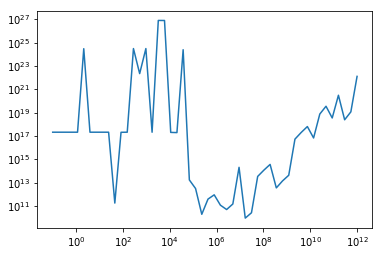

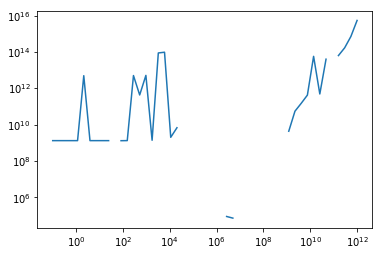

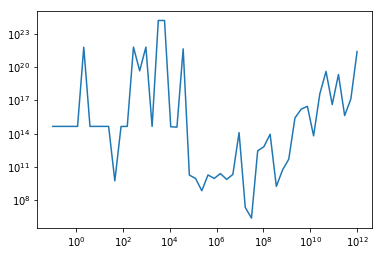

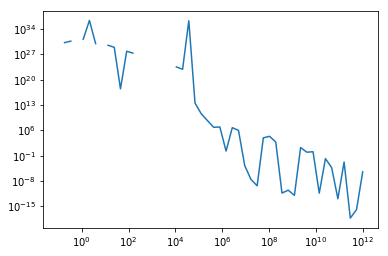

In [41]:
plt.figure()
plt.loglog(alphavec,MSE)
print(min(MSE))
print(np.where(MSE==min(MSE))[0])
plt.figure()
plt.loglog(alphavec,MSEprime)
print(min(MSEprime))
print(np.where(MSEprime==min(MSEprime)))
plt.figure()
plt.loglog(alphavec,chieff)

plt.figure()
plt.loglog(alphavec,chib)


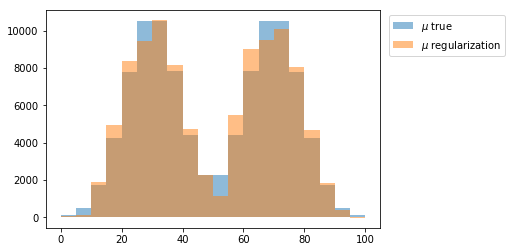

In [38]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ true')
#plt.bar(bin_midpoint,Nexperiment_d,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'Experiment')
plt.bar(bin_midpoint,mus_reg[np.where(MSE==min(MSE))[0][0],:],width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ regularization')
plt.legend(loc=2,bbox_to_anchor=(1.01, 1))

In [22]:
print np.all((B-Bopt)<1e-17)
print np.all((A-Aopt)<1e-8)

SyntaxError: invalid syntax (<ipython-input-22-605ce5576dd5>, line 1)

In [23]:
t = [137 , 273 , 696 , 1030 , 1370]
topt = [12 , 20 , 45 , 65 , 86]
n = [10, 20 , 50 , 75 , 100]
plt.plot(n,t,label='standard matrix creation')
plt.plot(n,topt,label='optimized matrix creation')
plt.legend()
plt.xlabel('# num alphas')
plt.ylabel('computation time (ms)')
print 'Expected computation time with opt version is %.1f s' %((topt[-1]-topt[0])*1./(n[-1]-n[0])*10)
print 'Expected computation time with standard version is %.1f s' %((t[-1]-t[0])*1./(n[-1]-n[0])*10)

SyntaxError: invalid syntax (<ipython-input-23-c681d47b94f9>, line 9)